# LSTM model
Long Short Term Memory network (LSTM) are a variant of RNN, which is capable of learning long-term dependencies. LSTMs are explicitly designed to avoid the long-term dependency problem, in which remembering information for a long period of time is a default behavior. As RNN, the form of LSTM is also a chain of repeating modules of neural network. However, while this repeating module have a simple structure in RNN such as a single tanh layer, there are four interacting layer in LSTM.

The key component of LSTMs is the cell state. Figure 1 illustrates the operation of a LSTM cell.

![](https://i.imgur.com/qkm8ROF.png)

The first step in the operation of a LSTM cell is to decide which information will be forgotten in the cell state. The decision is carried out by a 'forget' gate ($f_t$). The 'forget' gate output is calculated by the following equation.


$f_t$ = σ($W_f$ . [$h_{t-1}$, $x_t$] + $b_f$)

![](https://i.imgur.com/1ncItrC.png)


Here, $f_t$ is the output of the 'forget' gate, $W_f$ and $b_f$ are the 'forget' gate weight and bias, respectively, and [$h_{t-1}$, $x_t$] is the concatenated matrix of the previous time step's hidden state and the current time step's input.


The 'forget' gate output ($f_t$) is a matrix that contains the value between 0 and 1. Since the gate has the same dimension as the previous cell state $C_{t-1}$, they can be multiplied element-wise together. The element-wise multiplication of the two matrices $f_t$ * $C_{t-1}$ is like applying a 'mask' over the previous cell state $C_{t-1}$. If a single value in the 'forget' gate $f_t$ is equal or close to 0, the product of the element-wise multiplication is also equal or close to 0. Therefore, it prevents the information stored in the corresponding unit in $C_{t-1}$ from being 'remembered' in the next time step cell state.  

In the following step, the information, which might be stored in the current cell state $C_{t}$ needs to be decided. This could be done in such a way:

- A candidate value $\mathbf{\tilde{C}}_{t}$, which is a matrix containing information from the current time state that might be stored in the current cell state, is initialized.


$\mathbf{\tilde{C}}_{t}$ = tanh($W_c$ . [$h_{t-1}$, $x_t$] + $b_c$)

Here, tanh is the function that ouputs values between -1 and 1. $W_c$ and $b_c$ are the weight and bias to initialize the candidate value.

- The 'update' gate $i_{t}$, which is a matrix containing values between 0 and 1, decides wbat aspects of the newly initialized candidate value $\mathbf{\tilde{C}}_{t}$ in order to add to the current cell state $C_{t}$.

$i_{t}$ = σ($W_i$ . [$h_{t-1}$, $x_t$] + $b_i$)

Here, $i_t$ is the output of the 'update' gate, $W_i$ and $b_i$ are the 'update' gate weight and bias, respectively.


![](https://i.imgur.com/CrLyYxd.png)

Now it is possible to update the previous cell state $C_{t-1}$ to the new cell state $C_{t}$.

$C_{t}$ = $f_t$ * $C_{t-1}$ + $i_{t}$ * $\mathbf{\tilde{C}}_{t}$


![](https://i.imgur.com/CJdwdy5.png)

The update could be achieved by multiplying the old cell state matrix $C_{t-1}$ by 'forget gate' $f_t$. As a result, the things that were decided to 'forget' earlier, are not kept in the the current cell state matrix $C_{t}$. Afterwards, the product of $f_t$ * $C_{t-1}$ is added by $i_{t}$ * $\mathbf{\tilde{C}}_{t}$. The element-wise multiplication of the candidate value $\mathbf{\tilde{C}}_{t}$ by the 'update' gate $i_{t}$ scales how much candidate value $\mathbf{\tilde{C}}_{t}$ will be updated to the current cell state $C_{t}$.

Finally, a hidden cell state $h_{t}$ is constructed. The hidden cell state $h_{t}$ is created based on the current cell state $C_{t}$ and will be sent to the next LSTM cell.

$o_{t}$ = σ($W_o$ . [$h_{t-1}$, $x_t$] + $b_o$)

$h_{t}$ = $o_{t}$ * tanh($C_{t}$)

![](https://i.imgur.com/QAmDzza.png)


Here, it is important to note that the output gate $o_{t}$ is also like other gates in a LSTM cell. The gate contains values that range from 0 to 1. The ouput gate plays a role to decide how much the current cell state $C_{t}$ will be sent to the next LSTM cell through the hidden state $h_{t}$. $W_o$  and $b_o$ are the output gate weight and bias, respectively.

#Demo model

In [ ]:
# Importing required libraries
import nltk
import pandas as pd
from nltk.corpus import stopwords
from textblob import Word
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import wordcloud
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [ ]:
# Loading the dataset
df = pd.read_csv('/drive/My Drive/Kaggle_dataset/amazon_alexa.tsv', sep='\t')

In [ ]:
print(df)

      rating       date         variation  \
0          5  31-Jul-18  Charcoal Fabric    
1          5  31-Jul-18  Charcoal Fabric    
2          4  31-Jul-18    Walnut Finish    
3          5  31-Jul-18  Charcoal Fabric    
4          5  31-Jul-18  Charcoal Fabric    
...      ...        ...               ...   
3145       5  30-Jul-18        Black  Dot   
3146       5  30-Jul-18        Black  Dot   
3147       5  30-Jul-18        Black  Dot   
3148       5  30-Jul-18        White  Dot   
3149       4  29-Jul-18        Black  Dot   

                                       verified_reviews  feedback  
0                                         Love my Echo!         1  
1                                             Loved it!         1  
2     Sometimes while playing a game, you can answer...         1  
3     I have had a lot of fun with this thing. My 4 ...         1  
4                                                 Music         1  
...                                                

In [ ]:
df.verified_reviews.value_counts()

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      79
Love it!                                                                                                                                                                                                                                                                                                                                                                                                       

In [ ]:
# Creating a new column sentiment based on overall ratings
# Assume that if rating > 3.0 => positive rating
# If rating <= 3.0 => negative rating
def sentiments(df):
  if df['rating'] > 3.0:
    return 'Positive'
  elif df['rating'] < 3.0:
    return 'Negative'
  else:
    return 'Neutral'

df['sentiment'] = df.apply(sentiments, axis=1)

# Text Pre-processing

Cleaning the data. It includes removing the special characters, digits, unnecessary symbols, and stop words

In [ ]:
def print_plot(index):
    example = df[df.index == index][['verified_reviews', 'rating']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])
print_plot(1001)

This was given to my 7 year at the time as a birthday gift from his dad. He loves it, ask Alexa anything she has the answer, plus it’s good for homework. So I purchased one on prime day for my bathroom for when I’m getting ready for work. I listen to music at 4am and the base it’s metro booming.. Replacement for my clock radio, plus I have the echo dot on my night stand as my alarm clock..
Product: 5


In [ ]:
#Check if there are any null values
df_v1 = df[['verified_reviews','sentiment']]
df_v1.isnull().sum()

verified_reviews    0
sentiment           0
dtype: int64

In [ ]:
print(df_v1)

                                       verified_reviews sentiment
0                                         Love my Echo!  Positive
1                                             Loved it!  Positive
2     Sometimes while playing a game, you can answer...  Positive
3     I have had a lot of fun with this thing. My 4 ...  Positive
4                                                 Music  Positive
...                                                 ...       ...
3145  Perfect for kids, adults and everyone in betwe...  Positive
3146  Listening to music, searching locations, check...  Positive
3147  I do love these things, i have them running my...  Positive
3148  Only complaint I have is that the sound qualit...  Positive
3149                                               Good  Positive

[3150 rows x 2 columns]


In [ ]:
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string

        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing.
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwords from text
    return text

df_v1['verified_reviews'] = df_v1['verified_reviews'].apply(clean_text)
df_v1['verified_reviews'] = df_v1['verified_reviews'].str.replace('\d+', '') # replace digit by space

print(df_v1)

                                       verified_reviews sentiment
0                                             love echo  Positive
1                                                 loved  Positive
2     sometimes playing game answer question correct...  Positive
3     lot fun thing  yr old learns dinosaurs control...  Positive
4                                                 music  Positive
...                                                 ...       ...
3145                       perfect kids adults everyone  Positive
3146  listening music searching locations checking t...  Positive
3147  love things running entire home tv lights ther...  Positive
3148  complaint sound quality isnt great mostly use ...  Positive
3149                                               good  Positive

[3150 rows x 2 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
def print_plot(index):
    example = df_v1[df_v1.index == index][['verified_reviews', 'sentiment']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])

print_plot(1002)

impressed look clarity sound color
Product: Positive


# LSTM Modeling

. Vectorize the 'verified_reviews' by turning each text into either a sequence of integers or into a vector

. Limit the data set to the top 1000 words.

. Set the max number of words in each review at 250.

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 1000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 200


tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df_v1['verified_reviews'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 4181 unique tokens.


In [ ]:
# Truncate and pad the input sequences so that they are all in the same length for modeling.

X = tokenizer.texts_to_sequences(df_v1['verified_reviews'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (3150, 250)


In [ ]:
print(X)

[[  0   0   0 ...   0   1   2]
 [  0   0   0 ...   0   0 176]
 [  0   0   0 ...  66 256  21]
 ...
 [  0   0   0 ...  88  45  28]
 [  0   0   0 ... 602 679 107]
 [  0   0   0 ...   0   0  14]]


In [ ]:
# Converting categorical labels to numbers.
Y = pd.get_dummies(df['sentiment']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (3150, 3)


In [ ]:
# train test split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(2835, 250) (2835, 3)
(315, 250) (315, 3)


# Model

. The first layer is the embedded layer that uses 100 length vectors to represent each word.

. SpatialDropout1D performs variational dropout in NLP models.

. The next layer is the LSTM layer with 100 memory units.

. The output layer must create 3 output values, one for each class.

. Activation function is softmax for multi-class classification.

. Because it is a multi-class classification problem, categorical_crossentropy is used as the loss function.

In [ ]:
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/5
40/40 [==============================] - 37s 857ms/step - loss: 0.5723 - accuracy: 0.8514 - val_loss: 0.3870 - val_accuracy: 0.8979
Epoch 2/5
40/40 [==============================] - 34s 845ms/step - loss: 0.4260 - accuracy: 0.8679 - val_loss: 0.3184 - val_accuracy: 0.8979
Epoch 3/5
40/40 [==============================] - 34s 843ms/step - loss: 0.3095 - accuracy: 0.8910 - val_loss: 0.2778 - val_accuracy: 0.9049
Epoch 4/5
40/40 [==============================] - 34s 842ms/step - loss: 0.2236 - accuracy: 0.9181 - val_loss: 0.2626 - val_accuracy: 0.9085
Epoch 5/5
40/40 [==============================] - 38s 946ms/step - loss: 0.1810 - accuracy: 0.9306 - val_loss: 0.2776 - val_accuracy: 0.9120


In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

10/10 [==============================] - 1s 78ms/step - loss: 0.2379 - accuracy: 0.8984
Test set
  Loss: 0.238
  Accuracy: 0.898


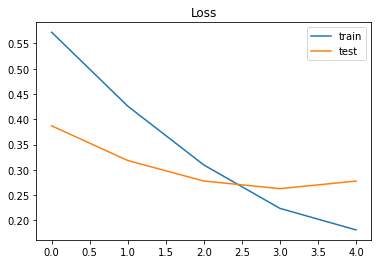

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

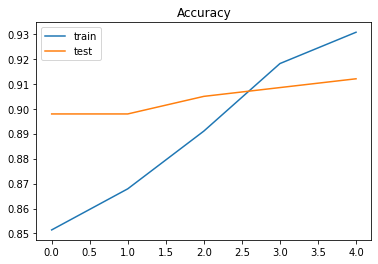

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

Source: # https://www.analyticsvidhya.com/blog/2021/06/natural-language-processing-sentiment-analysis-using-lstm/

https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17